# ROI Classifier

### This script uses a pre-trained net to label pre-extracted ROIs


Input ROIs: stat.npy file \
Input Net: .pth torch net file, PLUS you must copy and paste the architecture into this script

ROI Classification
--
Info about classes:  
This scripts includes a pretrained model to classify ROIs as one of the following categories:
- **Label 0:** Neuron + In-plane ("Great")
- **Label 1:** Neuron + Semi-in-plane ("Okay")
- **Label 4:** Neuron + Out of plane ("Poor")
- **Label 5:** Dendrite

(*note that during the manual labeling, 0-5 is actually 1-6*)  <br>
(*label 2 is for weird blobs and shadows of neurons*)  <br>
(*label 3 is empty on purpose*)  <br>
___

Info about CURRENT neural network:  
The network is trained on ~4700 ROIs from one FOV  
(mouse 6.28 , recorded on 20200903)  
- **Net_ROIClassifier_20200917.pth** state_dict file must be in path
- This script is specifically for the above .pth parameters file. Changes to the architecture cannot be made here.
___

Input data requirements of classifier net:
---
- 36x36 images
- dim1: image number
- dim 2,3: y,x
- should be normalized between 0-1  


- **There are cell blocks to use the 'stat.npy' output from Suite2p and convert to the required format**


- Full FOV size (in pixels) should be known. Default=512x1024
___



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# import sys
# import copy

import numpy as np

import scipy
import scipy.signal
from scipy.io import savemat

import matplotlib.pyplot as plt

import sys

import pathlib

In [3]:
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

Autodetected operating system: Windows. Using "\\" for directory slashes


In [ ]:
## lOAD & PREPROCESS stat.npy file
## outputs: 'images' (input into CNN)

dir_S2p_load = r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 11_20_N\20200325\suite2p\plane0'
fileName_stat_load = 'stat.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_stat_load}'
stat = np.load(path_load, allow_pickle=True)
print(f'stat file loaded from: {path_load}')

fileName_ops_load = 'ops.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_ops_load}'
ops = np.load(path_load, allow_pickle=True)
print(f'ops file loaded from: {path_load}')

fileName_F_load = 'F.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_F_load}'
F = np.load(path_load, allow_pickle=True)
print(f'F file loaded from: {path_load}')

fileName_Fneu_load = 'Fneu.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_Fneu_load}'
Fneu = np.load(path_load, allow_pickle=True)
print(f'Fneu file loaded from: {path_load}')

fileName_iscell_load = 'iscell.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_iscell_load}'
iscell = np.load(path_load, allow_pickle=True)
print(f'iscell file loaded from: {path_load}')

Number of ROIs: 4893


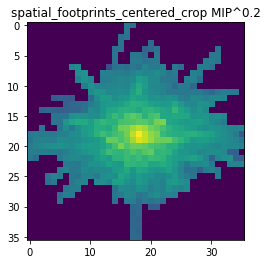

In [5]:
num_ROI = stat.shape[0]
print(f'Number of ROIs: {num_ROI}')

height = 512
width = 1024
spatial_footprints_centered = np.zeros((num_ROI, 241,241))
for i in range(num_ROI):
    spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

%matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

images = spatial_footprints_centered_crop

In [6]:
F_new = F - 0.7*Fneu
F_baseline = np.percentile(F_new , 30 , axis=1)
dFoF = (F_new - F_baseline[:,None]) / F_baseline[:,None]

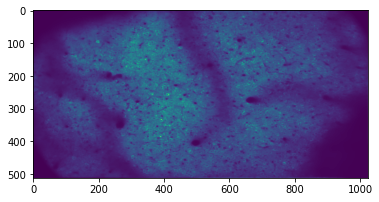

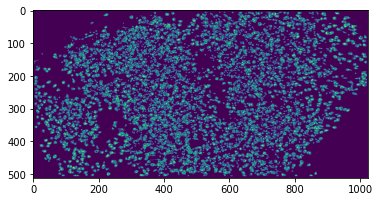

In [10]:
meanImg = ops[()]['meanImg']
frame_height = meanImg.shape[0]
frame_width = meanImg.shape[1]

plt.figure()
plt.imshow(meanImg)

masks_all_flat_norm = np.zeros_like(meanImg)
for ii in range(len(stat[()])):
    roi_current = stat[()][ii]['lam']
    masks_all_flat_norm[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = roi_current / np.max(roi_current)

plt.figure()
plt.imshow(masks_all_flat_norm)

In [11]:
## Define model architecture
## DO NOT CHANGE ANYTHING HERE!!!
## This architecture is linked to the .pth parameters file

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, PReLU, Softplus, Softmax2d
from torch.optim import Adam, SGD

In [12]:
dropout_prob = 0.0
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0),
#             Tanh(),
            ReLU(),
#             BatchNorm2d(6, momentum=momentum_val),
#             AvgPool2d(kernel_size=2),           
            
            Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=0),
            MaxPool2d(kernel_size=2, stride=2),           
#             Tanh(),
            ReLU(),
#             BatchNorm2d(16, momentum=momentum_val),
            Dropout(dropout_prob*1),
            
            Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1),
            MaxPool2d(kernel_size=2, stride=2),           
#             Tanh(),
            ReLU(),
#             BatchNorm2d(16, momentum=momentum_val),
            Dropout(dropout_prob*1),

            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
#             BatchNorm2d(16, momentum=momentum_val),
            MaxPool2d(kernel_size=2, stride=2),           
#             Tanh(),
            ReLU(),
            Dropout(dropout_prob*1),   
            
#             Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=1, padding=0),
#             Tanh(),
# #             ReLU(),
# #             MaxPool2d(kernel_size=2, stride=2),           
            
            
            
#             # Defining a 2D convolution layer
#             BatchNorm2d(1, momentum=momentum_val),
#             Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
#             BatchNorm2d(8, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
#             MaxPool2d(kernel_size=2, stride=2),
            
#            # Defining a 2D convolution layer
#             Conv2d(8, 16, kernel_size=4, stride=1, padding=1),
#             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
#             MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(64, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(256, 1024, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(1024, 32, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = Sequential(
            Linear(in_features=64, out_features=256),
#             Tanh(),
            ReLU(),
            Dropout(dropout_prob*1),

#             Linear(in_features=256, out_features=64),
# #             Tanh(),
#             ReLU(),
#             Dropout(dropout_prob*1),
            
            Linear(in_features=256, out_features=6),
            
            
#             Linear(1296, 512),
# #             Dropout(dropout_prob * 1),
#             ReLU(),
#             Softmax(dim=0),
# #             Sigmoid(),
            
            
#             Linear(216, 512),
#             Dropout(dropout_prob * 1),
#             ReLU(),

#             Linear(512, 6),
# #             ReLU(),
# #             Softmax(dim=0),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
#         x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = torch.flatten(x, 1)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
        x = self.linear_layers(x)
        return x 

In [13]:
#### ENTER FILENAME + PATH OF NETWORK .pth FILE

PATH_load_name_netParams = f'ROI_Classifier_20201004{slash_type}Net_trainedOnAug_20201004_trainingSet_mouse628_20200903and20200815.pth'
# PATH_load_name_netParams = f'ROI_Classifier_20200928{slash_type}Net_trainedOnAug_20200928_trainingSet_mouse628_20200903and20200815.pth'
# PATH_load_dir_netParams = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_netParams = f'{PATH_absolute}{slash_type}'

model = Net()
model.load_state_dict(torch.load(f'{PATH_load_dir_netParams}{PATH_load_name_netParams}'))
model.eval()

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Dropout(p=0.0, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [14]:
input_x = torch.tensor(images[:,None,:,:]).type('torch.FloatTensor')

output = model(input_x).cpu().detach().numpy()
softmax = np.exp(output)
prob = softmax
predictions = np.argmax(list(prob), axis=1)


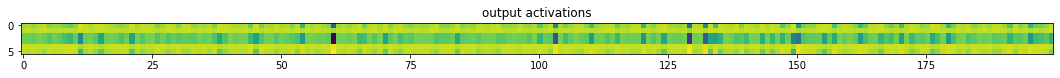

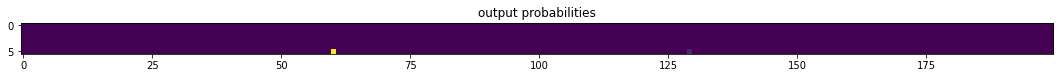

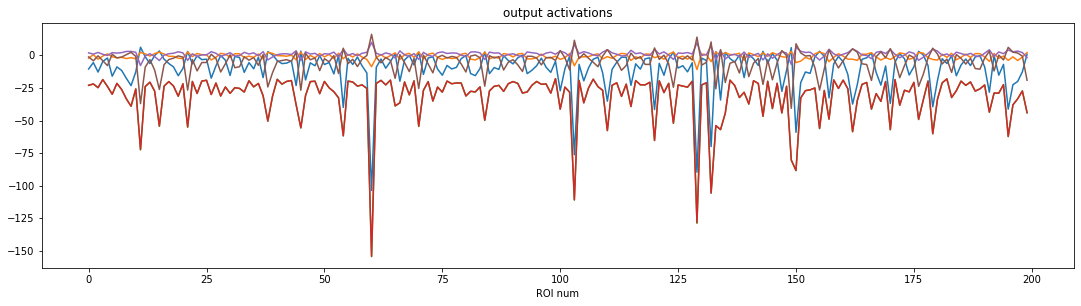

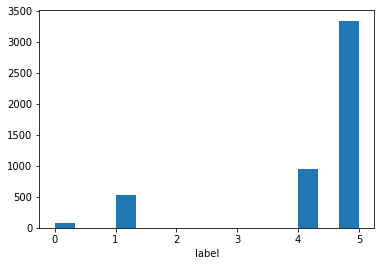

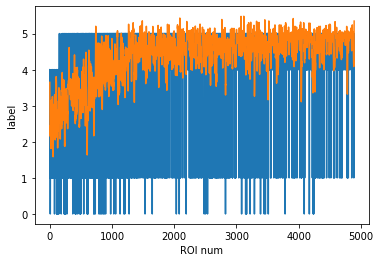

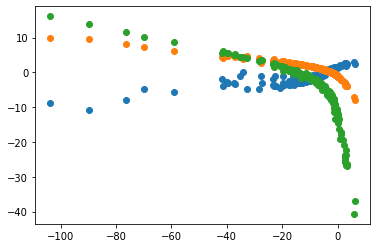

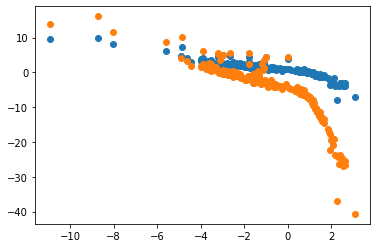

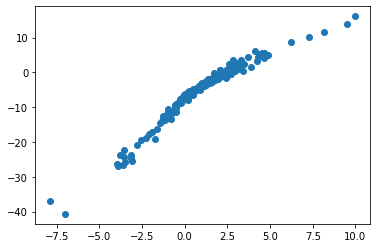

In [15]:
## Show some of the results

ind_to_plot =np.arange(100,300)

%matplotlib inline
fig_output = plt.figure()
plt.imshow(output[ind_to_plot,:].T);
plt.title('output activations');
fig_output.set_size_inches(18.5, 10.5)

fig_prob = plt.figure()
plt.imshow(prob[ind_to_plot,:].T);
plt.title('output probabilities');
fig_prob.set_size_inches(18.5, 10.5)

fig_prob_lines = plt.figure()
plt.plot(output[ind_to_plot,:])
plt.title('output activations');
plt.xlabel('ROI num')
fig_prob_lines.set_size_inches(18.5, 4.5)

fig_predHist = plt.figure()
plt.hist(predictions , 15);
plt.xlabel('label')

fig_predLines = plt.figure()
plt.plot(predictions);
plt.plot(scipy.signal.savgol_filter(predictions,19,3));
plt.xlabel('ROI num')
plt.ylabel('label')

fig_scatterGroups0 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([1])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups1 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups4 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([4])] , output[ind_to_plot , np.array([5])])

In [124]:
stat[1].keys()

dict_keys(['ypix', 'xpix', 'lam', 'footprint', 'mrs', 'mrs0', 'compact', 'med', 'npix', 'overlap', 'radius', 'aspect_ratio', 'npix_norm', 'skew', 'std'])

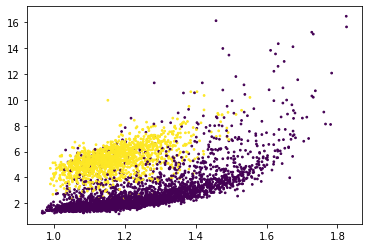

In [137]:
import sklearn as sk
import sklearn.cluster
## Define ROIs as cells or not
# I am finding that the intersection of a k-means on some stat params and the built in classifier probability is pretty good
num_cells = F.shape[0]
all_stat_keys = stat[1].keys()
all_stat_keys = np.array([*all_stat_keys])

# stat_keys_toUse = [3,4,5,6,8,9,10,11,13,14]
stat_keys_toUse = [8,10,11,13,14]
# stat_keys_toUse = [6,8,9,10,11, 13]

data_for_classifier = np.zeros((num_cells , len(stat_keys_toUse)))

for ii,val in enumerate(all_stat_keys[stat_keys_toUse]):
#     print(val)
#     print(ii)
    data_for_classifier[:,ii] = [stat[ii][val] for ii in range(len(stat))]


# data_for_classifier = np.hstack((data_for_classifier, iscell[:,1].reshape((iscell.shape[0],1))))

cluster_IDs = sk.cluster.KMeans(n_clusters=2, random_state=2637).fit(data_for_classifier).labels_

%matplotlib inline
h = plt.figure()
# plt.scatter(data_for_classifier[:,7], data_for_classifier[:,9], s=2, c=cluster_IDs)
# plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], [stat[ii]['radius'] for ii in range(num_cells)], s=3, c=cluster_IDs);
# plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], [stat[ii]['radius'] for ii in range(num_cells)], s=3, c=iscell[:,1] > 0.1);

is_cell_new = np.array(iscell[:,1] > 0.05) *  np.array(cluster_IDs == 0)
is_cleanROI_forPopulationAnalysis = np.array(iscell[:,1] > 0.05)

plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], 
            [stat[ii]['radius'] for ii in range(num_cells)], s=3, 
            c= is_cell_new);
#             c=cluster_IDs);
#             c=iscell[:,1] > 0.2);

In [243]:
data_for_classifier.shape
prob.shape

data_for_manifold = np.concatenate((output[:,np.array([0,1,4,5])] , data_for_classifier , iscell[:,1][:,None]) , axis=1)
# data_for_manifold = np.concatenate((prob[:,np.array([0,1,4,5])] , iscell[:,1][:,None]) , axis=1)
data_for_manifold.shape

(4893, 10)

In [244]:
from sklearn.manifold import TSNE, SpectralEmbedding, MDS, LocallyLinearEmbedding, Isomap

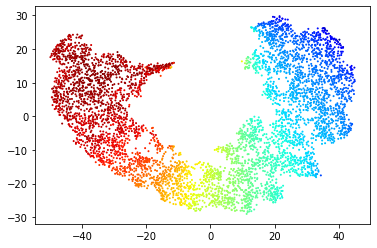

In [246]:
%matplotlib inline

# X_embedded = TSNE(n_components=2, perplexity=120).fit_transform(data_for_manifold[selector.ind,0:])
X_embedded = TSNE(n_components=2, perplexity=120).fit_transform(data_for_manifold[:,0:])

plt.figure()
# plt.scatter(X_embedded, np.zeros_like(X_embedded), c=output[:,0] , s=0.2, cmap='jet')
plt.scatter(X_embedded[:,0] , X_embedded[:,1], c=output[:,0] , s=1, cmap='jet')

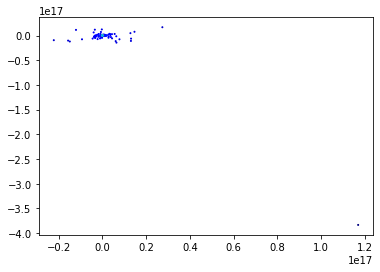

In [187]:
%matplotlib inline

X_embedded = MDS(n_components=2).fit_transform(data_for_manifold) 

plt.figure()
# plt.scatter(X_embedded, np.zeros_like(X_embedded), c=output[:,0] , s=0.2, cmap='jet')
plt.scatter(X_embedded[:,0] , X_embedded[:,1], c=output[:,0] , s=1, cmap='jet')

In [182]:
%matplotlib notebook

X_embedded = Isomap(1000, n_components=2).fit_transform(data_for_manifold)
# X_embedded = MDS(n_components=2).fit_transform(prob) 

plt.figure()
# plt.scatter(X_embedded, np.zeros_like(X_embedded), c=output[:,0] , s=0.2, cmap='jet')
plt.scatter(X_embedded[:,0] , X_embedded[:,1], c=output[:,0] , s=1, cmap='jet')

c:\users\rich hakim\.conda\envs\coding_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=1000 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


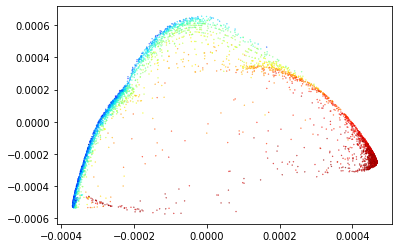

In [196]:
X_embedded2 = SpectralEmbedding(n_components=2, n_neighbors=2000).fit_transform(data_for_manifold[:,:])
plt.figure()
plt.scatter(X_embedded2[:,0] , X_embedded2[:,1], c=output[:,0] , s=0.1, cmap='jet')
# plt.scatter(X_embedded, np.zeros_like(X_embedded), c=output[:,0] , s=0.1, cmap='jet')

<ipython-input-16-a4bdfefa3a93>:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(prob2[:,:6]))


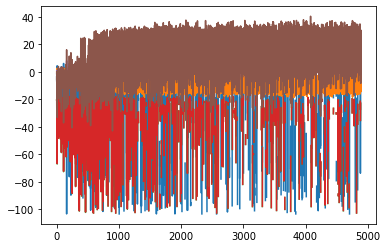

In [16]:
import copy 
prob2 = copy.deepcopy(prob)
prob2[:,4] = prob2[:,4] / 6
predictions2 = np.argmax(list(prob2), axis=1)
plt.figure()
plt.plot(np.log(prob2[:,:6]))

In [232]:
selections1 = selector.ind

In [334]:
%matplotlib notebook
import numpy as np

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path


class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, ind_toInclude, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)
        self.ind_toInclude = ind_toInclude
        
        # Ensure that we have separate colors for each object
        fig.canvas.draw()
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
        plotMasks(self , ax[1])
        fig.canvas.draw()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
#         self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

In [343]:
def plotMasks(selector , ax):
    toInc = selector.ind_toInclude[selector.ind]
    masks_all_selected = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
#     for ii in selector.ind:
    for ii in toInc:
        masks_all_selected[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] ] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_selected[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] ] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

    ax.imshow(masks_all_selected)

    print(f'Number of selected ROIs: {len(selector.ind)}')

In [344]:
%matplotlib notebook
if __name__ == '__main__':

    fig, ax = plt.subplots(nrows=2,ncols=1)
    
    pts = ax[0].scatter(X_embedded[:,0] , X_embedded[:,1] , s=5 , c=output[:,0] , cmap='jet')
    ind_toInclude = np.arange(X_embedded.shape[0])
    selector = SelectFromCollection(ax[0], pts, ind_toInclude)

    def keypress(event):
        if event.key == "enter":
#             print("Selected points:")
#             print(selector.xys[selector.ind])
            selector.disconnect()
#             ax.set_title("")
            fig.canvas.draw()
        if event.key == "shift":
            plotMasks(selector , ax[1])
            fig.canvas.draw()
        if event.key == "control":
            ax[0].clear()
            pts = ax[0].scatter(X_embedded[:,0] , X_embedded[:,1] , s=5 , c=output[:,0] , cmap='jet')
            fig.canvas.draw()
            ind_toInclude = np.arange(X_embedded.shape[0])
            selector.__init__(ax[0], pts, ind_toInclude)
    def subselect(threshold):
        ind_toInclude = np.where(output[:,0] > threshold)[0]
        print(f'Number of ROIs above threshold: {len(ind_toInclude)}')
        ax[0].clear()
        pts = ax[0].scatter(X_embedded[ind_toInclude,0] , X_embedded[ind_toInclude,1] , s=5 , c=output[ind_toInclude,0] , cmap='jet')
        fig.canvas.draw()
#         selector = SelectFromCollection(ax[0], pts)
        selector.__init__(ax[0], pts, ind_toInclude)


    
    fig.canvas.mpl_connect("key_press_event", keypress)
    ax[0].set_title("Press enter to accept selected points.")
    plt.show()
    
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(subselect, threshold=widgets.IntSlider(min=np.min(output[:,0]), max=30, step=1, value=np.min(output[:,0])));

interactive(children=(IntSlider(value=-259, description='threshold', max=30, min=-259), Output()), _dom_classe…

In [342]:
selected_ROIs = selector.ind_toInclude[selector.ind]
plt.figure()
plt.plot()

In [17]:
footprints_tall = np.zeros((frame_height*frame_width,4))*np.nan
cc = 0
for ii in range(len(stat)):
    num_pixels = len(stat[()][ii]['ypix'])
    footprints_tall[cc:cc+num_pixels,0] = np.ones(num_pixels)*ii
    footprints_tall[cc:cc+num_pixels,1] = stat[()][ii]['ypix']
    footprints_tall[cc:cc+num_pixels,2] = stat[()][ii]['xpix']
    footprints_tall[cc:cc+num_pixels,3] = stat[()][ii]['lam']
    cc = cc+num_pixels
footprints_tall = footprints_tall[~np.isnan(footprints_tall[:,0]),:]
# footprints_tall
# plt.figure()
# plt.plot(footprints_tall[:,3])

Number of Class 1 ROIs: 70
Number of Class 2 ROIs: 532
Number of Class 5 ROIs: 947
Number of Class 6 ROIs: 3344


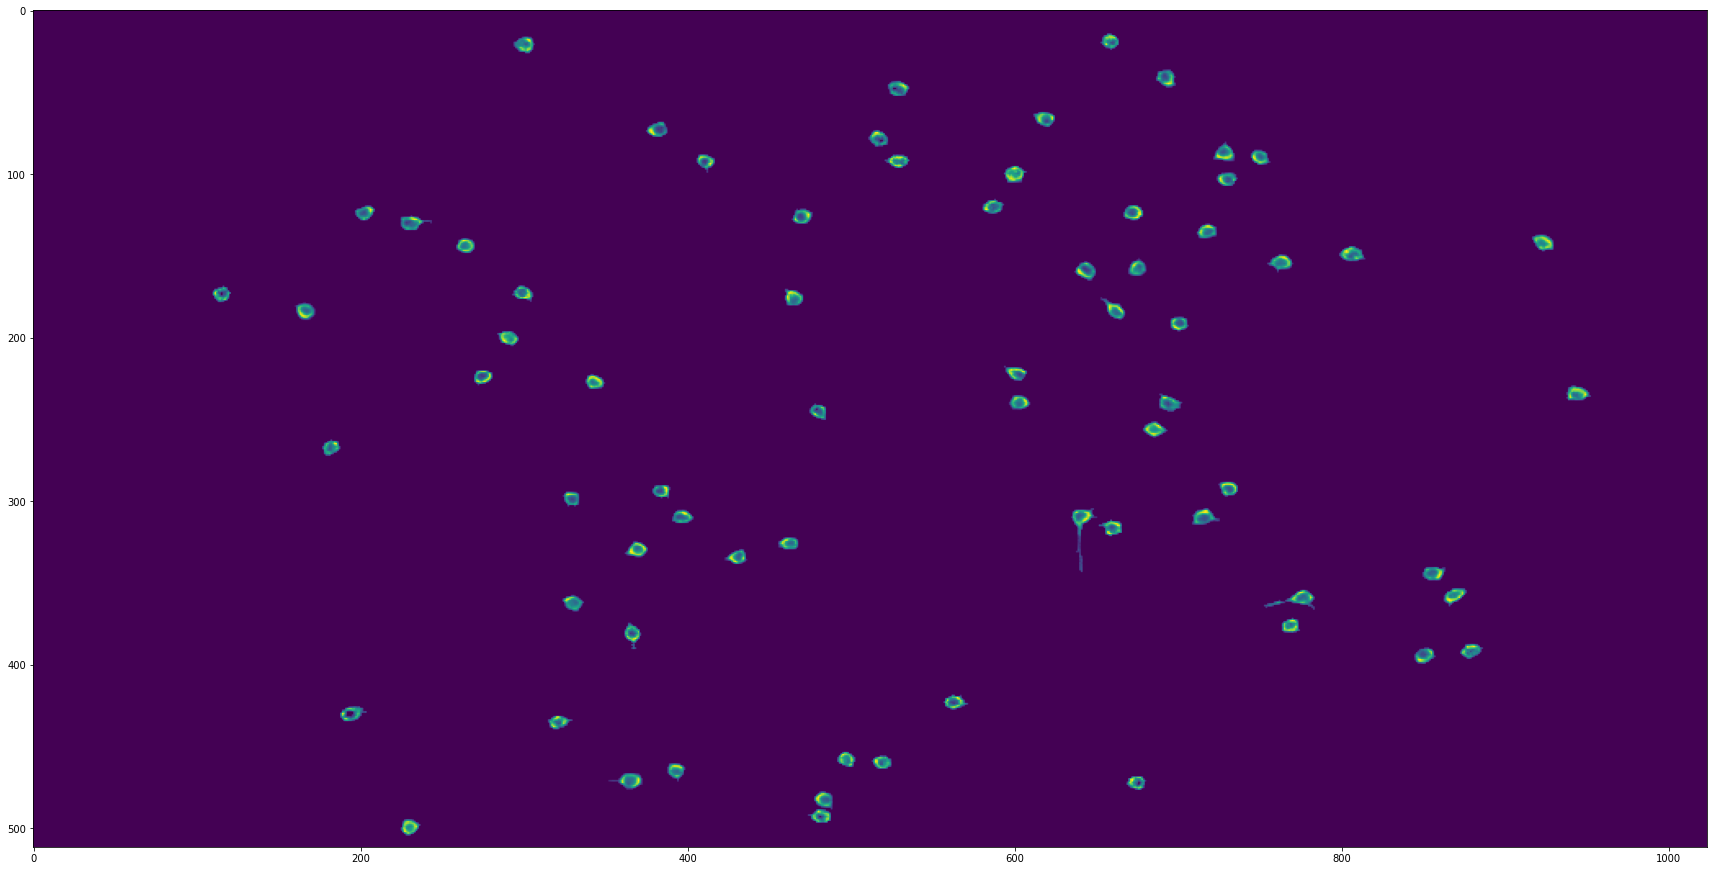

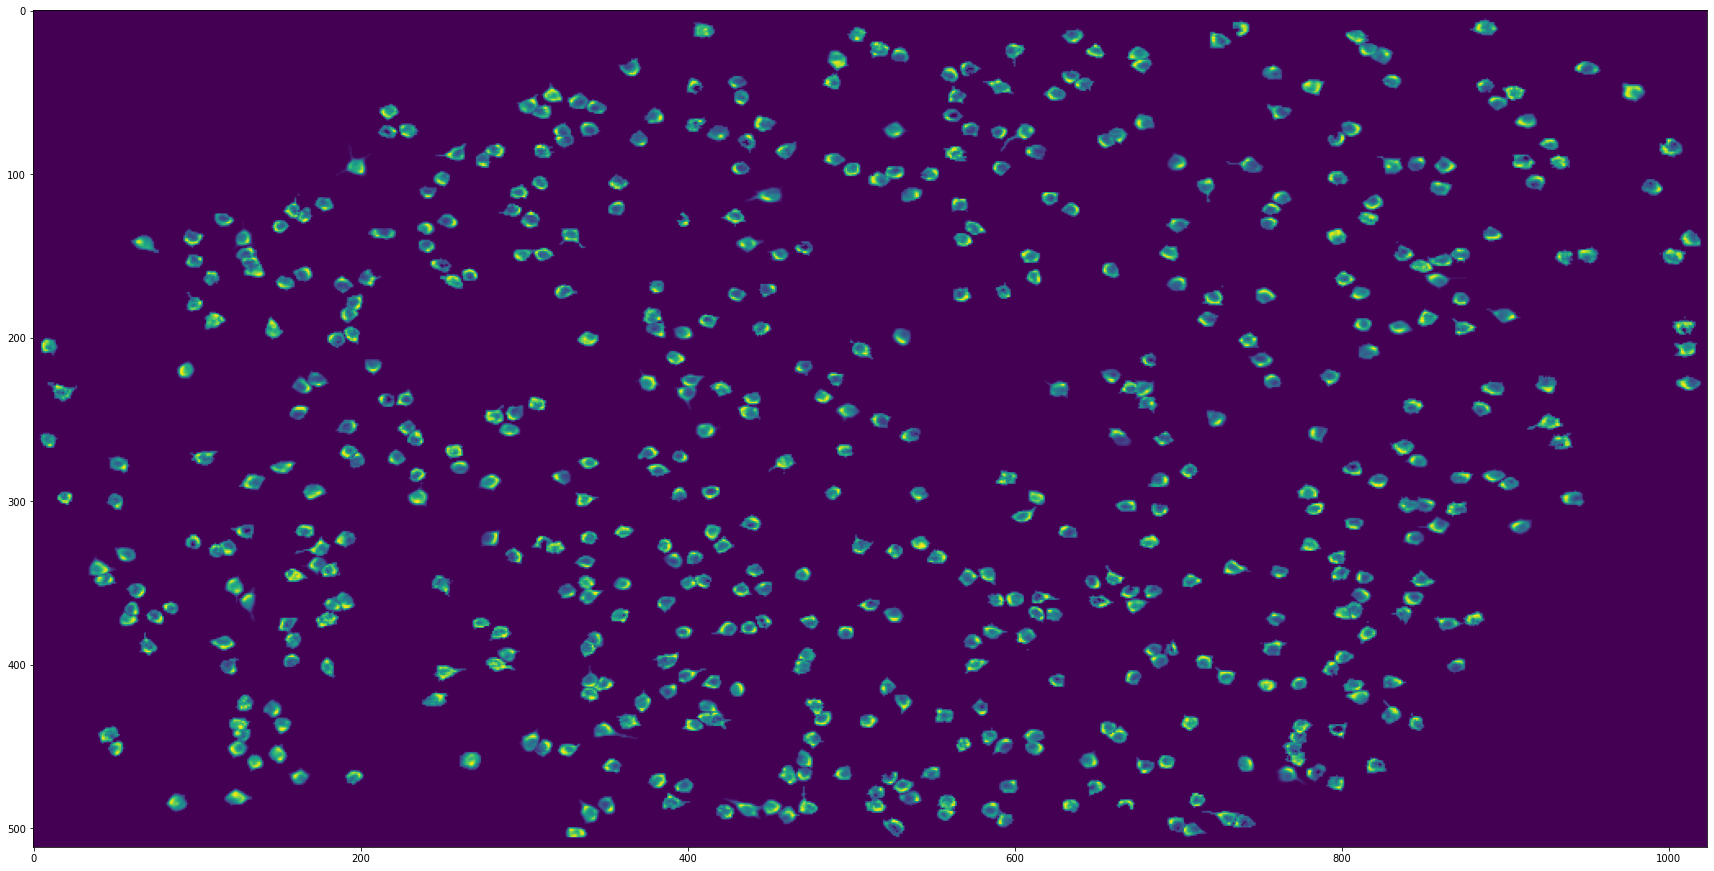

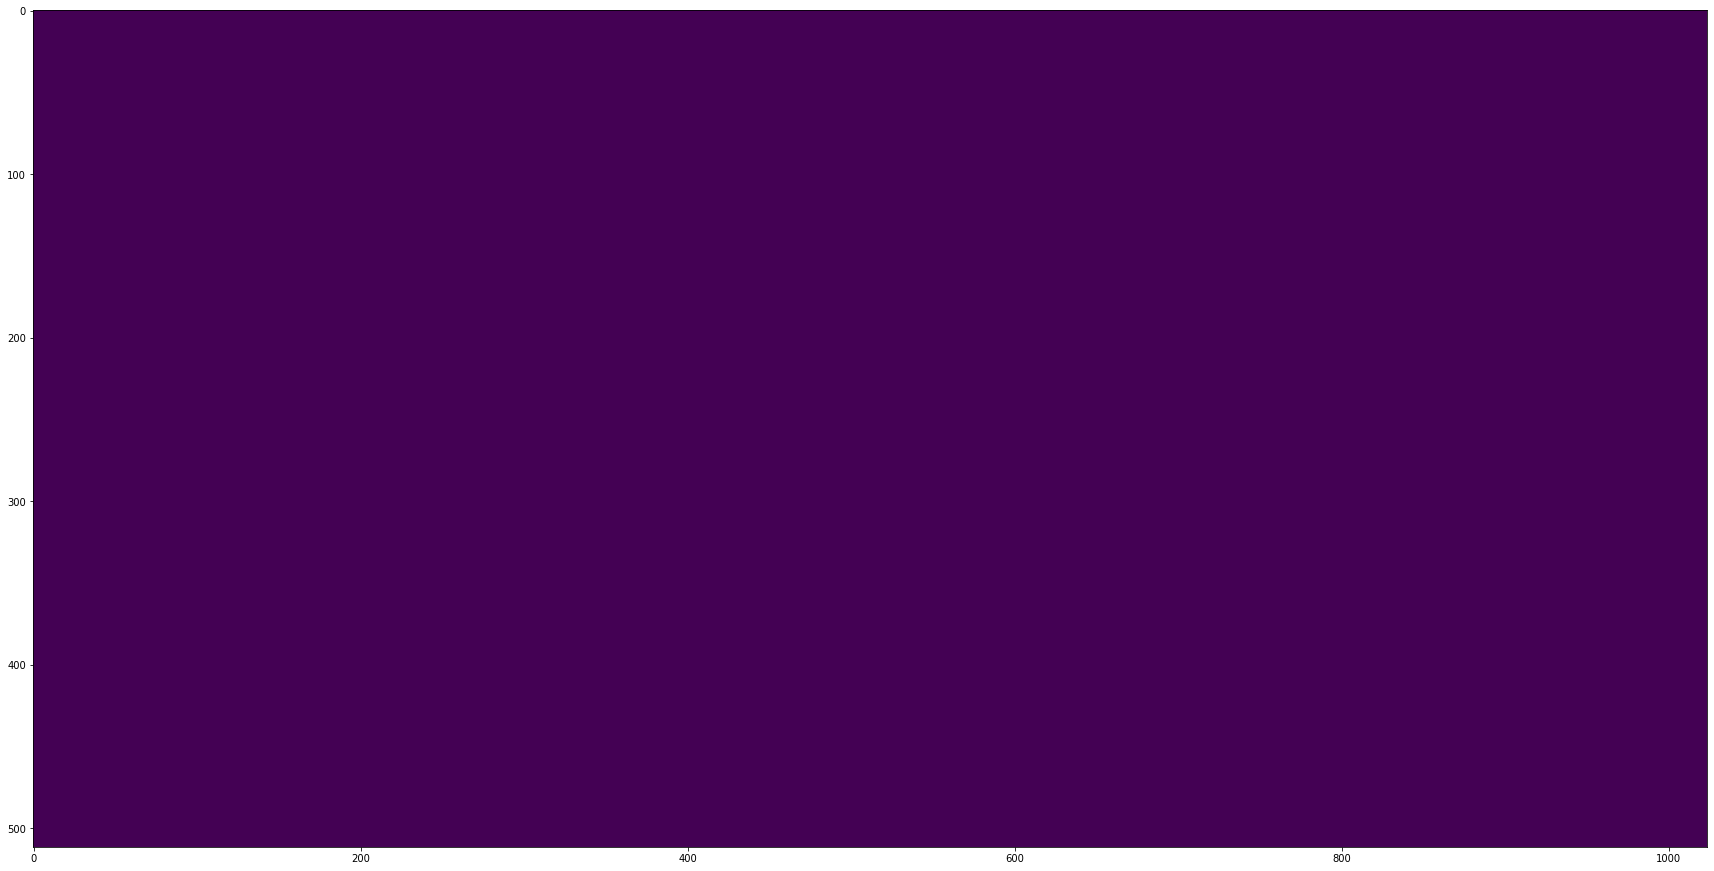

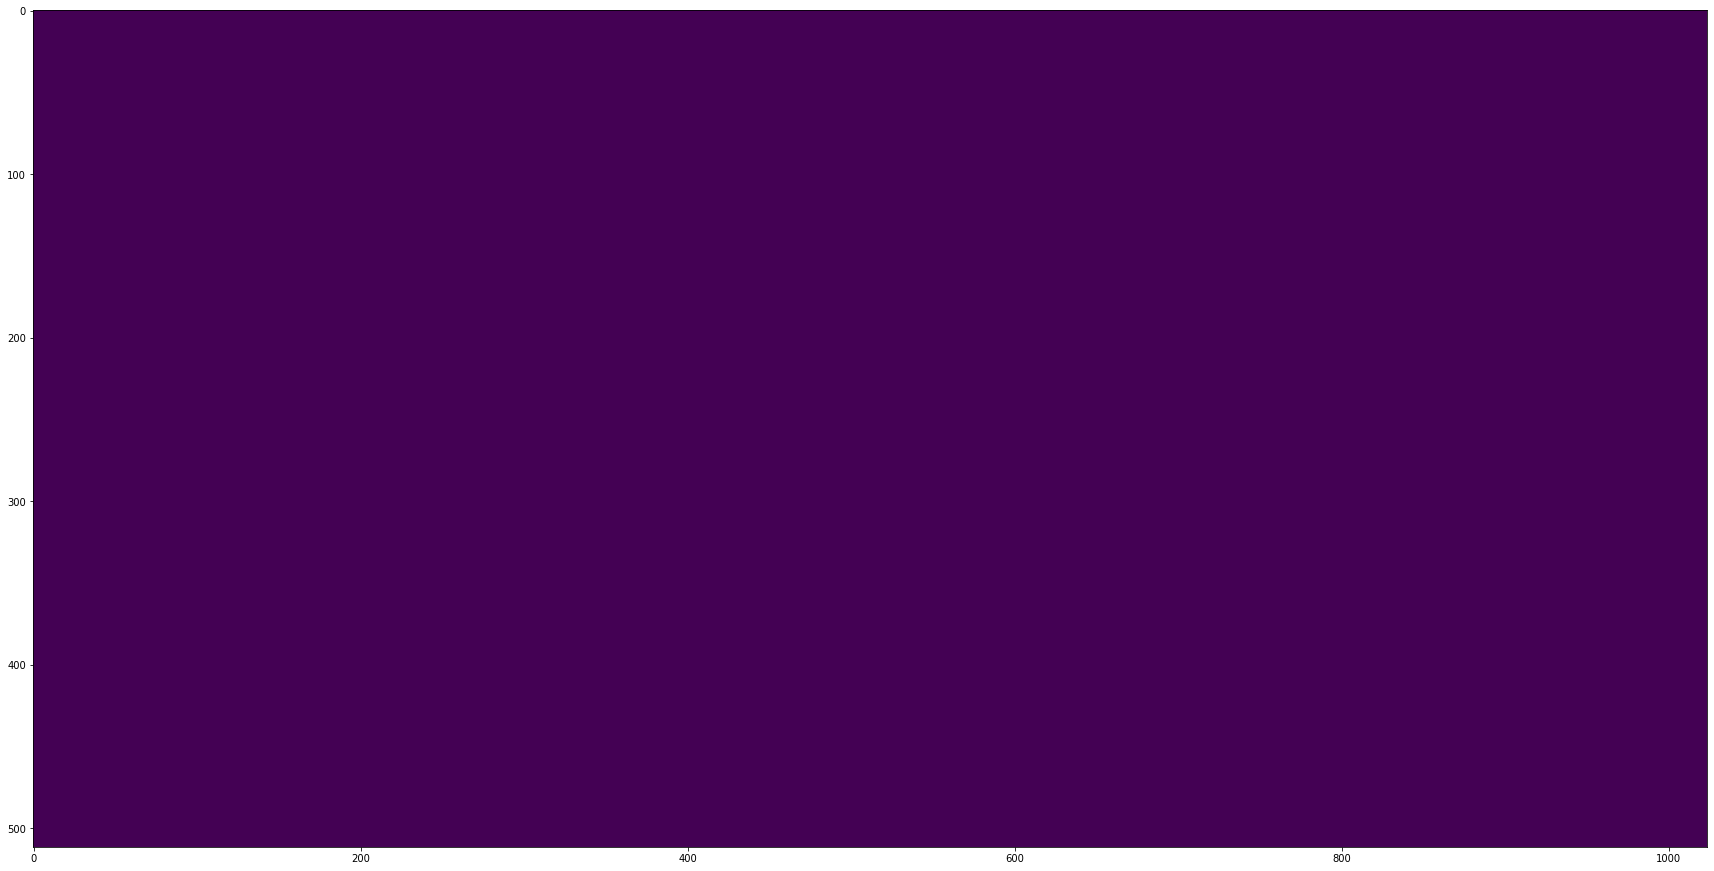

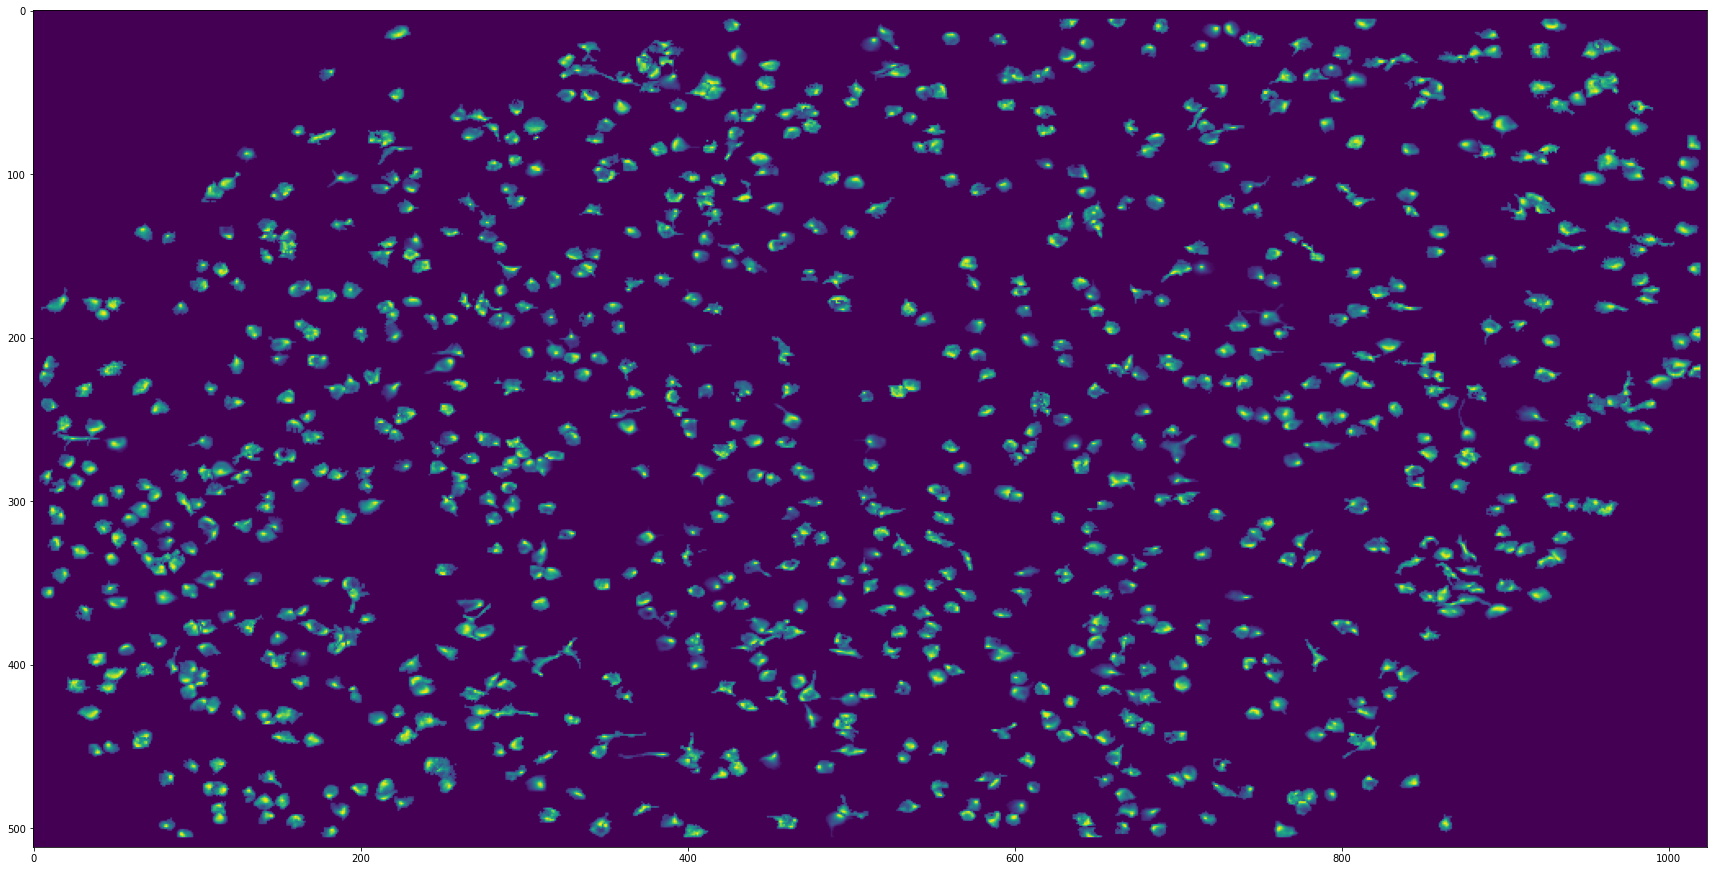

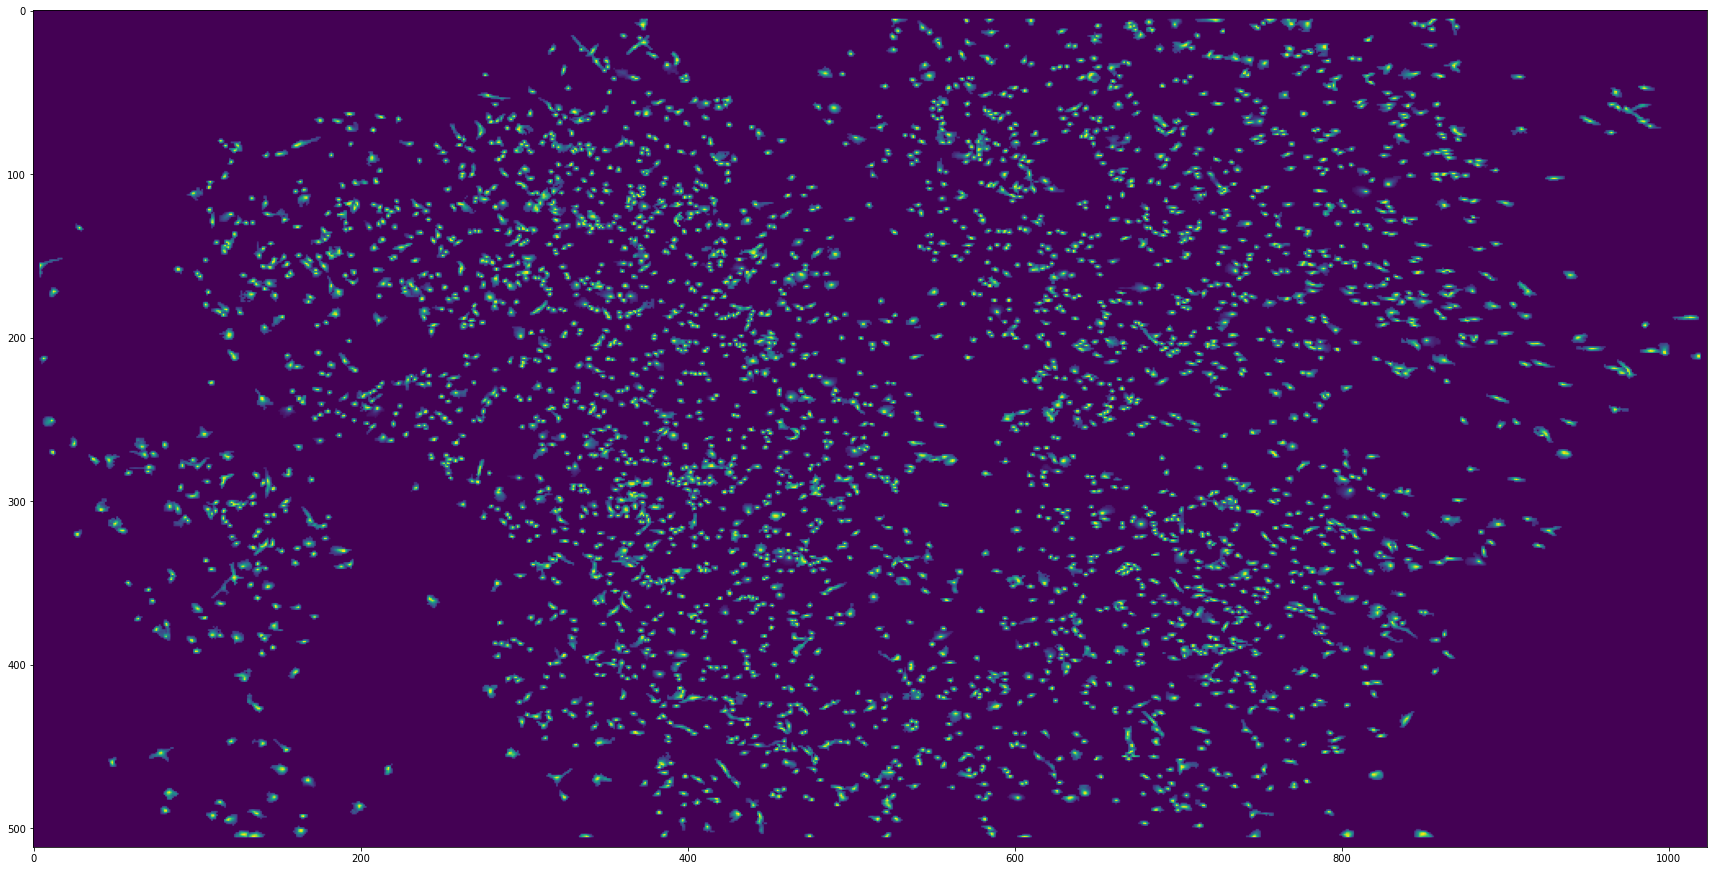

In [18]:
## Look at all the cells at once
%matplotlib inline

masks_all_classified = np.zeros((meanImg.shape[0] , meanImg.shape[1] , 6))
for jj in range(6):
    for ii in np.where(predictions==jj)[0]:
        masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam'] / (np.max(stat[()][ii]['lam'])**2)
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam']
    plt.figure(figsize=(30,20))
    plt.imshow(masks_all_classified[:,:,jj])
    
print(f'Number of Class 1 ROIs: {sum(predictions==0)}')
print(f'Number of Class 2 ROIs: {sum(predictions==1)}')
print(f'Number of Class 5 ROIs: {sum(predictions==4)}')
print(f'Number of Class 6 ROIs: {sum(predictions==5)}')

In [19]:
groups_to_include = [0,1,4]


In [20]:
toChange_list = list(np.zeros(predictions.shape[0])*np.nan)

In [21]:
## UNCOMMENT to Look at individual cells

## Press ENTER to advance. Press ESC to exit
## Press 1 to include or 0 to exclude or ENTER to leave as is

class_to_test = 4

def onKeyPress(event):
#     print('press', event.key)
    sys.stdout.flush()
    global cell_checked
    global exit_pref
    global toChange_list
    global ROI_iter
    if event.key == 'enter':
        cell_checked = 1
    elif event.key == 'escape':
        cell_checked = 1
        exit_pref = 1
    elif event.key.isnumeric():
        toChange_list[ROI_idx_totest[ROI_iter]] = event.key
        cell_checked = 1
    elif event.key == '-':
        ROI_iter-=2
        cell_checked = 1
    return

%matplotlib qt
# plt.figure()
# plt.pause(0.5) 
iter_start = 0
fig, (ax1, ax2) = plt.subplots(2, 1)
exit_pref = 0

# for ROI_iter in np.where(predictions ==class_to_test)[0]:
ROI_idx_totest = np.where(predictions ==class_to_test)[0]
ROI_iter = 0
while exit_pref==0 and ROI_iter<len(ROI_idx_totest):
    if ROI_idx_totest[ROI_iter] >= iter_start:
#             plt.subplot(2,1,1)
#             plt.imshow(images[ii, : , :])
#             plt.title(ii)
#             plt.subplot(2,1,2)
# #             plt.hold = False
#             plt.cla()
#             plt.plot(dFoF.T[:,ii])
        cell_checked = 0
        cid = fig.canvas.mpl_connect('key_press_event', onKeyPress)

        ax1.cla()
        ax1.imshow(images[ROI_idx_totest[ROI_iter], : , :])
        ax1.set_title(f'ROI#: {ROI_idx_totest[ROI_iter]}   ;   toChange={toChange_list[ROI_idx_totest[ROI_iter]]}')

        ax2.cla()
        ax2.plot(dFoF.T[:,ROI_iter])

        plt.show(block=False)
        while cell_checked==0:
            plt.pause(0.01) 
#         ROI_iter+=1
    ROI_iter+=1

#     if exit_pref==1:
#         break

#                 input_val = input()
#                 if not input_val:
#                     continue
#                 if np.int8(input_val) >=7:
#                     break
#                 plt.pause(0.05) 
plt.close()

In [28]:
fig.canvas.mpl_disconnect(cid)


In [26]:
%matplotlib qt
plt.figure()
plt.plot(toChange[~np.isnan(toChange)] < 5)

In [27]:
# find idx of ROIs to change
idx_toChange = np.array(toChange_list)
idx_toChange = idx_toChange!='nan' 

toChange = np.zeros(predictions.shape[0])*np.nan
toChange[idx_toChange]=np.array(toChange_list)[idx_toChange]
# plt.figure()
# plt.plot(toChange ,'.')

<ipython-input-27-fb95ccec4896>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  idx_toChange = idx_toChange!='nan'


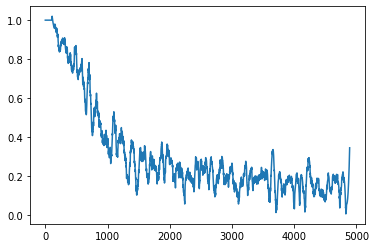

In [28]:
%matplotlib inline
toInclude = np.array([predictions[ii] in groups_to_include for ii in range(len(predictions))] , dtype=bool)
plt.figure()
plt.plot(scipy.signal.savgol_filter(toInclude,101,3))

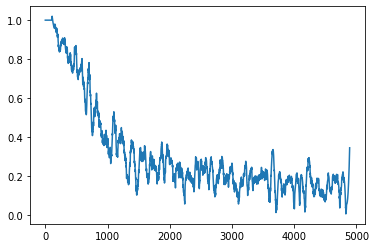

In [29]:
toInclude[~np.isnan(toChange)] = toChange[~np.isnan(toChange)] < 5
plt.figure()
plt.plot(scipy.signal.savgol_filter(toInclude,101,3))

In [44]:
## USE iscell (OPTIONAL)

toInclude = iscell[:,0]
toExclude = toInclude==0

In [45]:
toExclude_manuallyClicked = np.zeros_like(toInclude)
toInclude_manuallyClicked = np.zeros_like(toInclude)

In [46]:
np.sum(toInclude) - np.sum(- toExclude_manuallyClicked)

1313.0

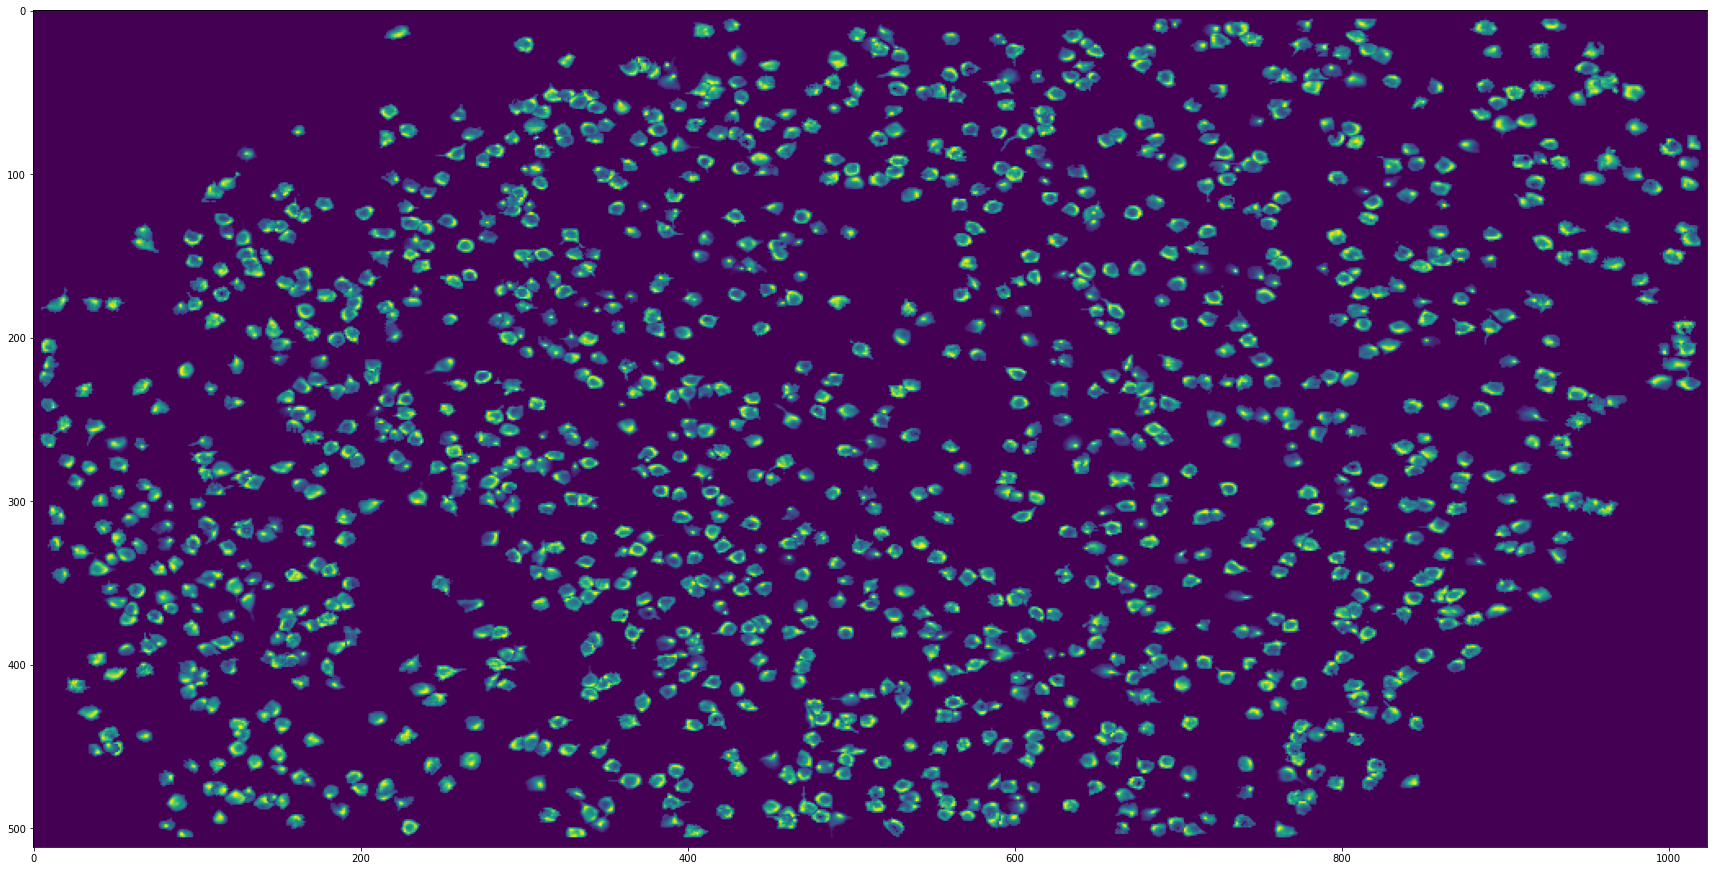

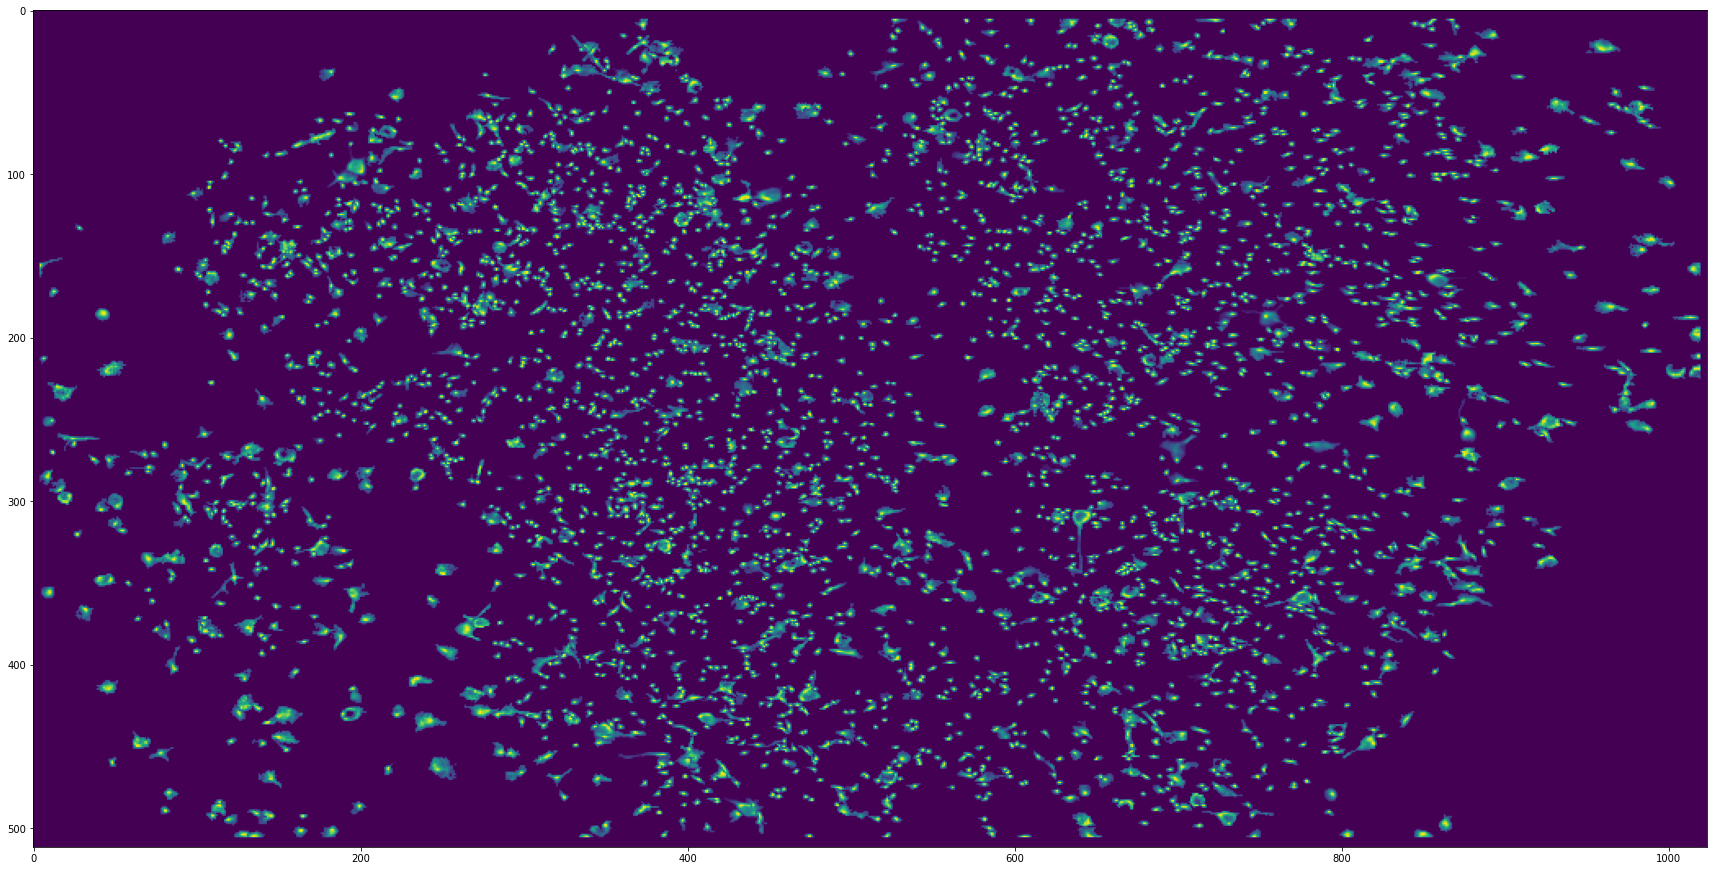

In [47]:
## Look at all the cells at once
%matplotlib inline

masks_toInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
masks_toExclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
for ii in np.where(np.uint8(toInclude) - toExclude_manuallyClicked)[0]:
    masks_toInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
for ii in np.where(np.uint8(toExclude) - toInclude_manuallyClicked)[0]:
    masks_toExclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam'] / (np.max(stat[()][ii]['lam'])**2)
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam']
plt.figure(figsize=(30,20))
plt.imshow(masks_toInclude)
plt.figure(figsize=(30,20))
plt.imshow(masks_toExclude)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
from scipy.integrate import trapz
from matplotlib import animation
%matplotlib qt
%matplotlib qt

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def append_ROI_toExclude(coords):
    global toExclude_manuallyClicked
    global footprints_tall
    pixel_match_bool = (footprints_tall[:,1] == np.round(coords[-1][1])) * (footprints_tall[:,2] == np.round(coords[-1][0]))
    check_found_single_ROI = sum(pixel_match_bool)
    if check_found_single_ROI:
        ROI_toExclude = int(footprints_tall[np.where(pixel_match_bool)[0][0] , 0])
        print(f'Excluding ROI#: {ROI_toExclude}')
        if ROI_toExclude in np.where(toInclude)[0]:
            toExclude_manuallyClicked[ROI_toExclude] = 1
    
# Simple mouse click function to store coordinates
def onclick(event):
    if event.button is MouseButton.LEFT:

        global ix, iy
        ix, iy = event.xdata, event.ydata
#         print(event)

        # print 'x = %d, y = %d'%(
        #     ix, iy)

        # assign global variable to access outside of function
        global coords
        coords.append((ix, iy))
        
        append_ROI_toExclude(coords)
        update_image()
        return

def update_image():
    masks_toInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
    for ii in np.where(np.uint8(toInclude) - toExclude_manuallyClicked)[0]:
        masks_toInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
    ax1.clear()
    im = ax1.imshow(masks_toInclude)
    plt.draw()
    

fig, (ax1) = plt.subplots(1, 1, figsize=(30,20))
im = ax1.imshow(masks_toInclude)
plt.show(block=False)
# ani = animation.FuncAnimation(fig, update_image, interval=0)

plt.pause(2) 
            
coords = []

# Call click func
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# plt.show(1)

Excluding ROI#: 672
Excluding ROI#: 829
Excluding ROI#: 1237
Excluding ROI#: 747
Excluding ROI#: 401
Excluding ROI#: 448
Excluding ROI#: 201
Excluding ROI#: 201
Excluding ROI#: 394
Excluding ROI#: 1115
Excluding ROI#: 803
Excluding ROI#: 580
Excluding ROI#: 1030
Excluding ROI#: 429
Excluding ROI#: 193
Excluding ROI#: 519
Excluding ROI#: 1036
Excluding ROI#: 898
Excluding ROI#: 838
Excluding ROI#: 232
Excluding ROI#: 75
Excluding ROI#: 304
Excluding ROI#: 348
Excluding ROI#: 331
Excluding ROI#: 1306
Excluding ROI#: 1394
Excluding ROI#: 772
Excluding ROI#: 359
Excluding ROI#: 499


In [50]:
fig.canvas.mpl_disconnect(cid)

Final number of included ROIs:  1286.0
Final number of NOT included ROIs:  3607.0


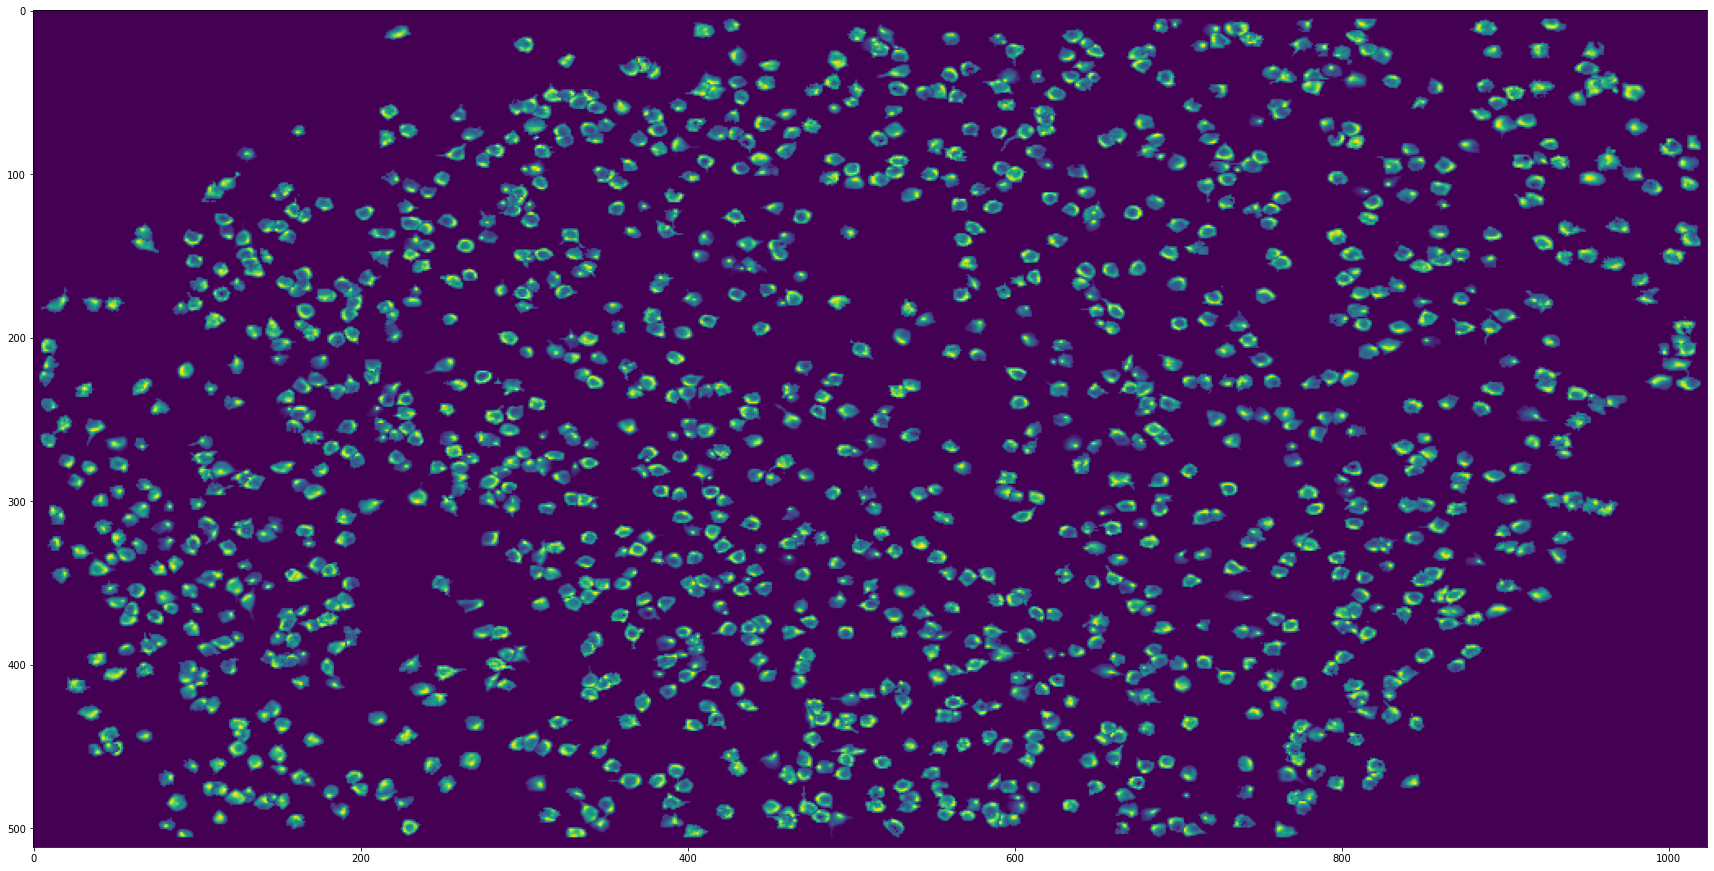

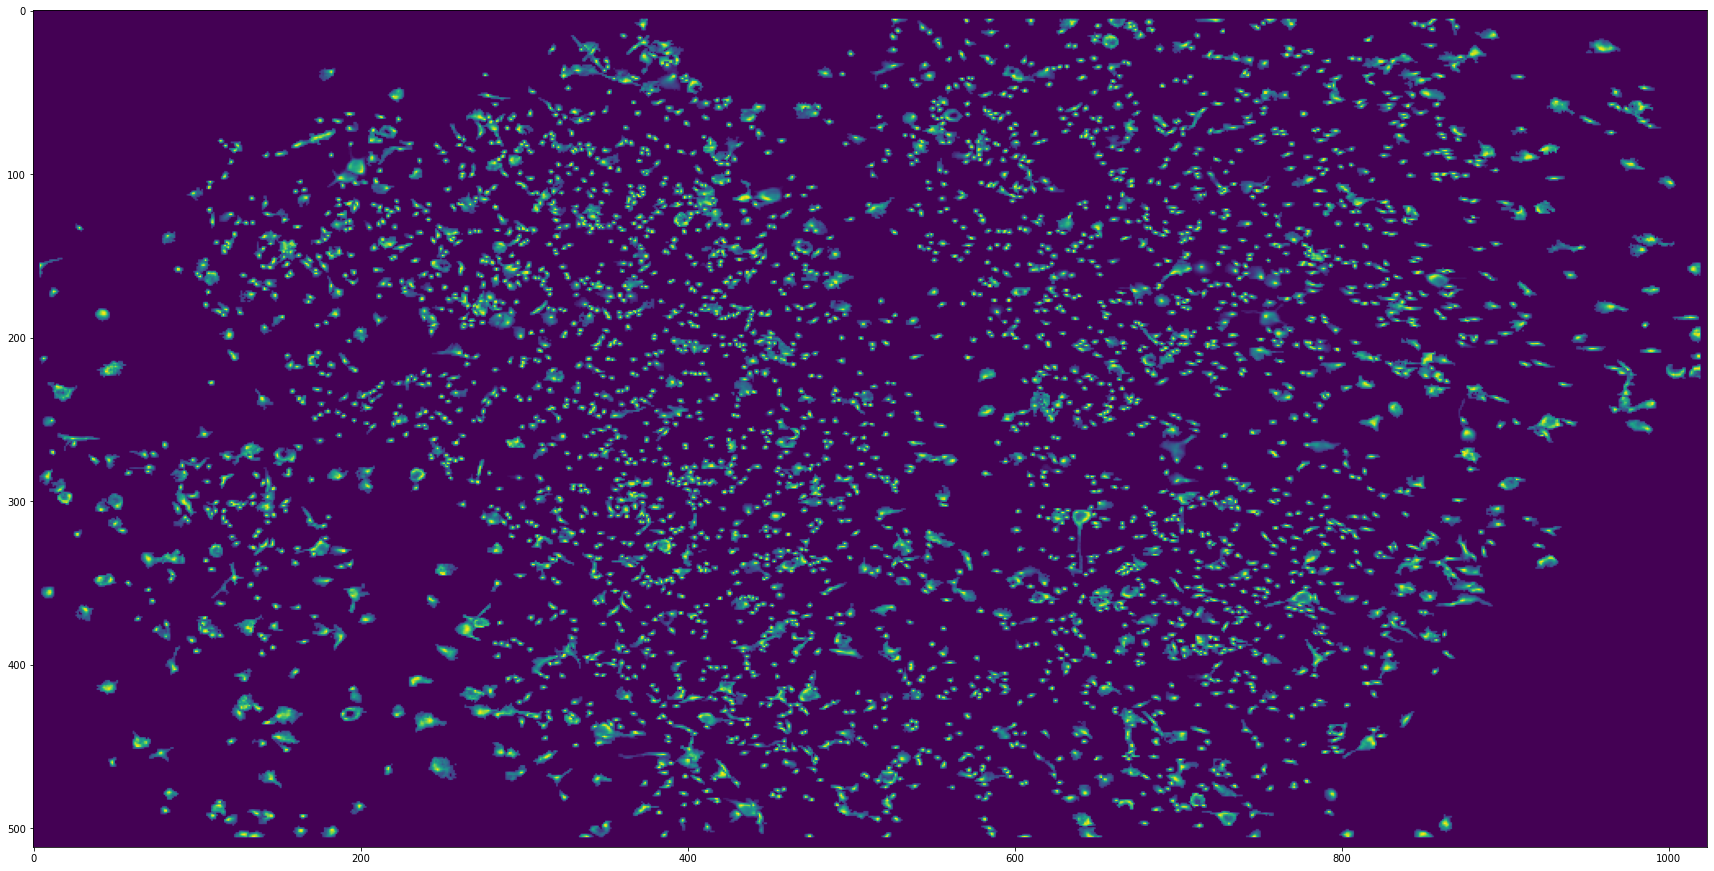

In [51]:
toInclude_final = np.uint8(toInclude) - toExclude_manuallyClicked
print(f'Final number of included ROIs:  {np.sum(toInclude_final)}')
print(f'Final number of NOT included ROIs:  {np.sum(1-toInclude_final)}')

## Look at all the cells at once
%matplotlib inline

masks_toInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
masks_notToInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
for ii in np.where(toInclude_final)[0]:
    masks_toInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
for ii in np.where(1-toInclude_final)[0]:
    masks_notToInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

plt.figure(figsize=(30,20))
plt.imshow(masks_toInclude)
plt.figure(figsize=(30,20))
plt.imshow(masks_notToInclude)

In [52]:
# manual curation variables:
manual_selection_vars = dict([
    ('toInclude_preExclusion', toInclude), 
    ('toExclude_manuallyClicked', toExclude_manuallyClicked), 
    ('predictions', predictions),
    ('output_activations', output),
    ('prob', prob),
    ('toInclude_final', toInclude_final)
    ])

In [50]:
save_dir = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112'

save_name = f'IsCell_ROIClassifier'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , toInclude_final)

save_name = f'manual_selection_vars'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , manual_selection_vars)

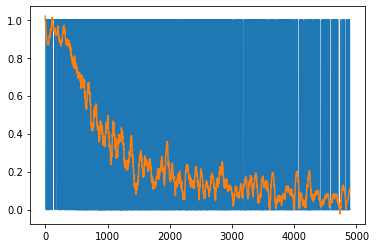

In [53]:
plt.figure()
plt.plot(toInclude_final)
plt.plot(scipy.signal.savgol_filter(toInclude_final,101,3))